In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles

In [47]:
random_seed = 123
N = 100
K = 10
colors = ["#FF4500", "#228B22", "#FFA500", "#32CD32"]

In [48]:
# Generate drifted dataset

X, Y = make_blobs(n_samples=N*4, n_features=2, centers=[[-2,-2],[3,3],[0,-1],[4,5]], cluster_std=2, random_state=random_seed)

source_idx0 = Y == 0
source_idx1 = Y == 1
target_idx0 = Y == 2
target_idx1 = Y == 3

X_source = X[source_idx0 | source_idx1]
X_target = X[target_idx0 | target_idx1]

y_source = Y[source_idx0 | source_idx1]
y_target = Y[target_idx0 | target_idx1] - 2

print(X_source.shape, X_target.shape, y_source.shape, y_target.shape)

(200, 2) (200, 2) (200,) (200,)


In [49]:
# Select target data to label
from sklearn.model_selection import train_test_split

X_target_labeled, X_target_unlabeled, y_target_labeled, y_target_unlabeled = train_test_split(X_target, y_target, train_size=K/N, random_state=0)

print(X_target_labeled.shape, X_target_unlabeled.shape, y_target_labeled.shape, y_target_unlabeled.shape)

(20, 2) (180, 2) (20,) (180,)


In [44]:
# Dump data
import numpy as np

with open("toy_data/cluster.npy", "wb") as f:
    np.save(f, X_source)
    np.save(f, y_source)
    np.save(f, X_target_labeled)
    np.save(f, y_target_labeled)
    np.save(f, X_target_unlabeled)
    np.save(f, y_target_unlabeled)


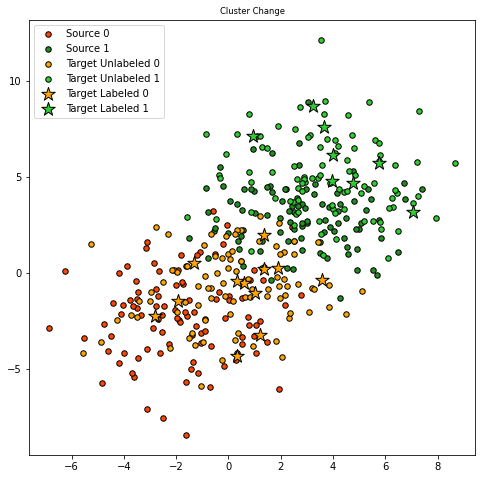

In [50]:
plt.figure(figsize=(8, 8))
plt.title("Cluster Change", fontsize="small")

s0 = plt.scatter(X_source[y_source==0][:, 0], X_source[y_source==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k')
s1 = plt.scatter(X_source[y_source==1][:, 0], X_source[y_source==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k')
s2 = plt.scatter(X_target_unlabeled[y_target_unlabeled==0][:, 0], X_target_unlabeled[y_target_unlabeled==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k')
s3 = plt.scatter(X_target_unlabeled[y_target_unlabeled==1][:, 0], X_target_unlabeled[y_target_unlabeled==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k')
s4 = plt.scatter(X_target_labeled[y_target_labeled==0][:, 0], X_target_labeled[y_target_labeled==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k')
s5 = plt.scatter(X_target_labeled[y_target_labeled==1][:, 0], X_target_labeled[y_target_labeled==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k')
plt.legend((s0, s1, s2, s3, s4, s5), ("Source 0", "Source 1", "Target Unlabeled 0", "Target Unlabeled 1", "Target Labeled 0", "Target Labeled 1"))

plt.show()

In [10]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch

torch.set_num_threads(32)

In [11]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ToyModel(nn.Module):
    def __init__(self, inc=2, cls=2):
        super(ToyModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(inc, 3),
            nn.ReLU(),
            nn.Linear(3, cls)
        )

    def forward(self, x):
        return self.classifier(x)

In [12]:
# Test the model

def test(model, loader, tag="Test"):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    overall_loss = 0
    is_correct = []
    with torch.no_grad():
        for data in loader:
            X, y = data
            y_pred = model(X.float())
            loss = criterion(y_pred, y.long())
            probs = F.softmax(y_pred, dim=-1)
            _, predvals = torch.max(probs, 1)
            is_correct.extend((predvals == y).cpu().data.numpy())
            overall_loss += loss.item() / len(loader)
    accuracy = np.mean(np.array(is_correct, dtype=np.int64))
    print(f"[{tag}] loss: {overall_loss}, accuracy: {accuracy}")
    return overall_loss, accuracy

In [54]:
# Train the model

def train(train_loader, valid_loader, test_loader, seed=0, epochs=100000, log_interval=100, early_stop=10):
    torch.manual_seed(seed)

    model = ToyModel()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    losses = []
    best_valid_acc = 0
    best_test_acc = 0
    counter = 0
    for i in range(epochs):
        model.train()
        for data in train_loader:
            X, y = data
            y_pred = model(X.float())
            loss = criterion(y_pred, y.long())
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i % log_interval == 0:
            print(f"[Train] epoch {i}, loss: {loss.item()}, last {log_interval} averaged loss: {np.mean(losses)}")
            test(model, valid_loader, tag="Train")
            _, valid_acc = test(model, valid_loader, tag="Valid")
            _, test_acc = test(model, test_loader, tag="Test")
            losses = []

            if valid_acc >= best_valid_acc:
                best_valid_acc = valid_acc
                best_test_acc = test_acc
            if valid_acc > best_valid_acc:
                counter = 0    
            else:
                counter += 1

            if counter > early_stop:
                print("Early stop!")
                break
    print(f"Best valid acc: {best_valid_acc}, best test acc: {best_test_acc}")
    return model

In [55]:
# Train: source + k labeled target
# Valid: k labeled target
# Test: unlabeled target

train_dataset = ToyDataset(np.concatenate((X_source, X_target_labeled[:K]), axis=0), np.concatenate((y_source, y_target_labeled[:K]), axis=0))
valid_dataset = ToyDataset(X_target_labeled[K:], y_target_labeled[K:])
test_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model0 = train(train_loader, valid_loader, test_loader)

[Train] epoch 0, loss: 0.7797889113426208, last 100 averaged loss: 0.7797889113426208
[Train] loss: 1.0844370126724243, accuracy: 0.3
[Valid] loss: 1.0844370126724243, accuracy: 0.3
[Test] loss: 0.9881453514099121, accuracy: 0.3333333333333333
[Train] epoch 100, loss: 0.16375526785850525, last 100 averaged loss: 0.28867473259568216
[Train] loss: 0.5029600858688354, accuracy: 0.8
[Valid] loss: 0.5029600858688354, accuracy: 0.8
[Test] loss: 0.3718433082103729, accuracy: 0.8277777777777777
[Train] epoch 200, loss: 0.13068781793117523, last 100 averaged loss: 0.1402905347943306
[Train] loss: 0.5618871450424194, accuracy: 0.8
[Valid] loss: 0.5618871450424194, accuracy: 0.8
[Test] loss: 0.3507660925388336, accuracy: 0.8611111111111112
[Train] epoch 300, loss: 0.12744493782520294, last 100 averaged loss: 0.12855444714426995
[Train] loss: 0.6251723170280457, accuracy: 0.8
[Valid] loss: 0.6251723170280457, accuracy: 0.8
[Test] loss: 0.3676644265651703, accuracy: 0.8611111111111112
[Train] epoch

In [53]:
# Train: source
# Valid: labeled target
# Test: unlabeled target

train_dataset = ToyDataset(X_source, y_source)
valid_dataset = ToyDataset(X_target_labeled, y_target_labeled)
test_dataset = ToyDataset(X_target_unlabeled, y_target_unlabeled)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model1 = train(train_loader, valid_loader, test_loader)

[Train] epoch 0, loss: 0.7706544399261475, last 100 averaged loss: 0.7706544399261475
[Train] loss: 1.0067503452301025, accuracy: 0.3
[Valid] loss: 1.0067503452301025, accuracy: 0.3
[Test] loss: 0.9881453514099121, accuracy: 0.3333333333333333
[Train] epoch 100, loss: 0.15362925827503204, last 100 averaged loss: 0.2760433562099934
[Train] loss: 0.48953333497047424, accuracy: 0.8
[Valid] loss: 0.48953333497047424, accuracy: 0.8
[Test] loss: 0.3991534411907196, accuracy: 0.8222222222222222
[Train] epoch 200, loss: 0.11977519094944, last 100 averaged loss: 0.13075867295265198
[Train] loss: 0.5010238885879517, accuracy: 0.8
[Valid] loss: 0.5010238885879517, accuracy: 0.8
[Test] loss: 0.3849843442440033, accuracy: 0.8555555555555555
[Train] epoch 300, loss: 0.11530020087957382, last 100 averaged loss: 0.11688765905797481
[Train] loss: 0.536475419998169, accuracy: 0.8
[Valid] loss: 0.536475419998169, accuracy: 0.8
[Test] loss: 0.4082801342010498, accuracy: 0.8555555555555555
[Train] epoch 40

In [14]:
import pytorch_influence_functions as ptif

ptif.init_logging()
config = ptif.get_default_config()
config['gpu'] = -1
config['dataset'] = 'Toy'
config['num_classes'] = 2
config['test_sample_num'] = 10

influences, harmful, helpful = ptif.calc_img_wise(config, model, train_loader, valid_loader)

2021-07-18 05:39:16,553: Running on: 10 images per class.
2021-07-18 05:39:16,556: Starting at img number: 0 per class.


In [58]:
# Plot decision boundary

def predict(model, X):
 #Convert into numpy element to tensor
 X = torch.from_numpy(X).type(torch.FloatTensor)
 #Predict and return ans
 pred = model(X)
 prob = F.softmax(pred, dim=-1)
 _, predval = torch.max(prob, 1)
 return predval.numpy()

def plot_decision_boundary(model):
    # Set min and max values and give it some padding
    x_min = min(X_source[:, 0].min(), X_target_labeled[:, 0].min(), X_target_unlabeled[:, 0].min()) - .5
    x_max = max(X_source[:, 0].max(), X_target_labeled[:, 0].max(), X_target_unlabeled[:, 0].max()) + .5
    y_min = min(X_source[:, 1].min(), X_target_labeled[:, 1].min(), X_target_unlabeled[:, 1].min()) - .5
    y_max = max(X_source[:, 1].max(), X_target_labeled[:, 1].max(), X_target_unlabeled[:, 1].max()) + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # print(xx[:5], yy[:5])
    # print(xx.shape, yy.shape)
    # print(np.c_[xx.ravel(), yy.ravel()])


    # Predict the function value for the whole gid
    Z = predict(model, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 8))
    plt.title("Cluster Decision Boundary", fontsize="small")
    # # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

    s0 = plt.scatter(X_source[y_source==0][:, 0], X_source[y_source==0][:, 1], marker='o', c=colors[0], s=30, edgecolor='k')
    s1 = plt.scatter(X_source[y_source==1][:, 0], X_source[y_source==1][:, 1], marker='o', c=colors[1], s=30, edgecolor='k')
    s2 = plt.scatter(X_target_unlabeled[y_target_unlabeled==0][:, 0], X_target_unlabeled[y_target_unlabeled==0][:, 1], marker='o', c=colors[2], s=30, edgecolor='k')
    s3 = plt.scatter(X_target_unlabeled[y_target_unlabeled==1][:, 0], X_target_unlabeled[y_target_unlabeled==1][:, 1], marker='o', c=colors[3], s=30, edgecolor='k')
    s4 = plt.scatter(X_target_labeled[y_target_labeled==0][:, 0], X_target_labeled[y_target_labeled==0][:, 1], marker='*', c=colors[2], s=200, edgecolor='k')
    s5 = plt.scatter(X_target_labeled[y_target_labeled==1][:, 0], X_target_labeled[y_target_labeled==1][:, 1], marker='*', c=colors[3], s=200, edgecolor='k')
    plt.legend((s0, s1, s2, s3, s4, s5), ("Source 0", "Source 1", "Target Unlabeled 0", "Target Unlabeled 1", "Target Labeled 0", "Target Labeled 1"))

    plt.show()

{'outdir': 'outdir',
 'seed': 42,
 'gpu': 0,
 'dataset': 'CIFAR10',
 'num_classes': 10,
 'test_sample_start_per_class': False,
 'test_sample_num': 1,
 'test_start_index': 0,
 'recursion_depth': 1,
 'r_averaging': 1,
 'scale': None,
 'damp': None,
 'calc_method': 'img_wise',
 'log_filename': None}

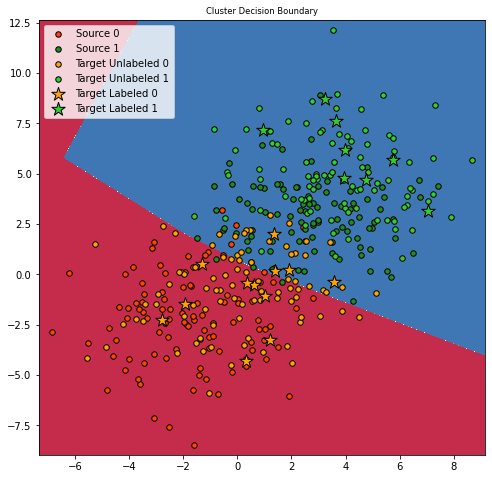

In [56]:
plot_decision_boundary(model0)


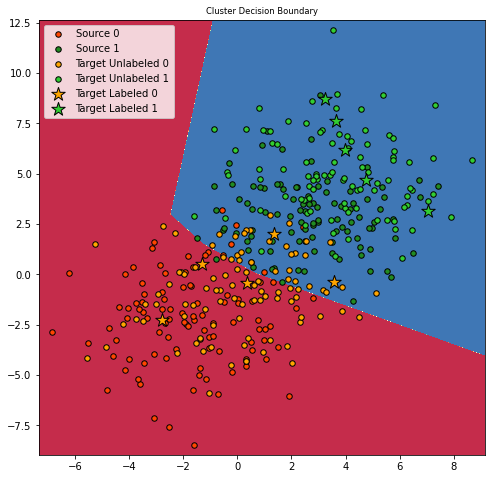

In [46]:
plot_decision_boundary(model1)